Samgeo

In [2]:
import os
import leafmap
from samgeo import SamGeo, tms_to_geotiff, get_basemaps
import torch

In [3]:
m = leafmap.Map(center=[ 41.305760, -81.017707], zoom=16)
m.add_basemap("OpenStreetMap")
m

OpenStreetMap has been already added before.


Map(center=[41.30576, -81.017707], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title',…

In [3]:
image = "satellite (1).tif"

In [4]:
# tms_to_geotiff(output=image, bbox=m.user_roi_bounds(), zoom=20, source="Satellite", overwrite=True)

In [6]:
# m.layers[-1].visible = False 
m.add_raster('overlap_zeors.tif', layer_name="Image")
m

Map(bottom=1568122.0, center=[41.305763, -81.01769949999999], controls=(ZoomControl(options=['position', 'zoom…

In [6]:
import torch
torch.cuda.is_available()

True

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [8]:
device

'cuda'

In [27]:
sam = SamGeo(
    model_type="vit_h",
    checkpoint="sam_vit_h_4b8939.pth",
    automatic=False,
    sam_kwargs=None,
    device='cuda'
)

In [28]:
sam.set_image(image)

In [26]:
image = 'output_resample.tif'

In [ ]:
m = sam.show_map()
m

Text Prompts

In [ ]:
import leafmap
from samgeo import tms_to_geotiff
from samgeo.text_sam import LangSAM

In [ ]:
sam = LangSAM()

Un-supervised Classification

In [64]:
import rasterio
from rasterio import plot
import matplotlib.pyplot as plt
from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt
from datetime import date
import numpy as np
from sklearn.cluster import KMeans, DBSCAN
import cv2


In [45]:
imagePath = 'output_resample.tif'

In [46]:
with rasterio.open(imagePath) as b:
    bands = b.read()
image_array = np.transpose(bands, (1, 2, 0))

In [49]:
image_array = cv2.GaussianBlur(image_array, (7, 7), 0) 

In [50]:
image_array.shape

(2866, 4448, 3)

In [51]:
# Reshape the image to (pixels, bands) for clustering
pixels = image_array.reshape(-1, image_array.shape[2])


In [66]:
kmeans = KMeans(n_clusters=8, random_state=42)
# kmeans = DBSCAN()
kmeans.fit(pixels)

KMeans(random_state=42)

In [67]:
labels = kmeans.labels_

In [68]:
# Reshape the labels back to the original image shape (height, width)
classified_image = labels.reshape(image_array.shape[0], image_array.shape[1])


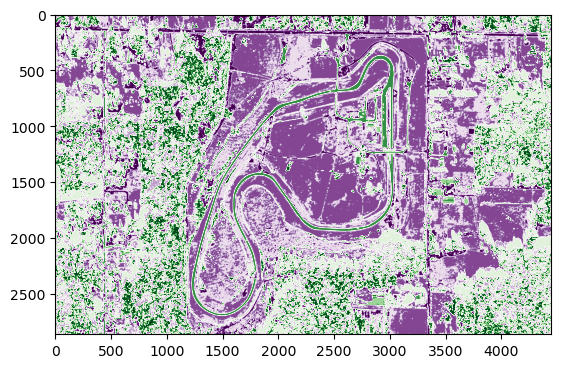

In [69]:
plt.imshow(classified_image, cmap='PRGn')

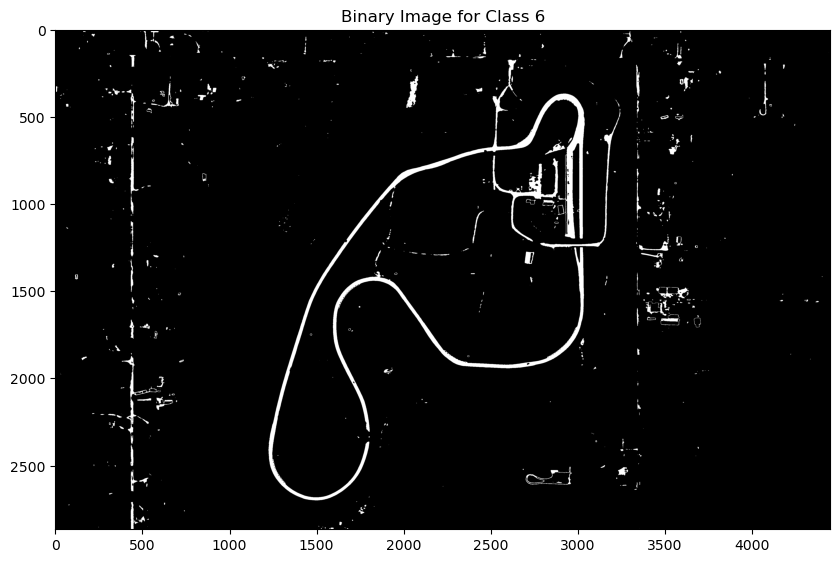

In [70]:
# Select a specific label (e.g., class 2)
selected_label = 6

# Create a binary image: 1 for the selected class, 0 for others
binary_image = (classified_image == selected_label).astype(int)

plt.figure(figsize=(10,10))
plt.imshow(binary_image, cmap='gray')
plt.title(f'Binary Image for Class {selected_label}')
plt.show()

In [74]:
np.unique(binary_image)

array([0, 1])

In [99]:
# opening = cv2.morphologyEx(binary_image.astype(np.uint8), cv2.MORPH_CLOSE, 
#                            np.ones((5, 5), np.uint8) , iterations=1)

opening = cv2.dilate(binary_image.astype(np.uint8),np.ones((2, 2), np.uint8) , iterations=1)

In [86]:
# Save the binary image as a new GeoTIFF file
with rasterio.open(
    'binary_output_blur_new.tif',
    'w',
    driver='GTiff',
    height=binary_image.shape[0],
    width=binary_image.shape[1],
    count=1,  # Single band for the binary image
    dtype=binary_image.dtype,
    crs=b.crs,
    transform=b.transform
) as dst:
    dst.write(binary_image, 1)

print("Binary image saved as 'binary_output_blur_new.tif'")


Binary image saved as 'binary_output_blur_new.tif'


In [101]:
# Save the binary image as a new GeoTIFF file
with rasterio.open(
    'opening.tif',
    'w',
    driver='GTiff',
    height=opening.shape[0],
    width=opening.shape[1],
    count=1,  # Single band for the binary image
    dtype=opening.dtype,
    crs=b.crs,
    transform=b.transform
) as dst:
    dst.write(opening, 1)

print("Binary image saved as 'opening.tif'")


Binary image saved as 'opening.tif'
